In [87]:
import pandas as pd
import numpy as np
import nltk
import json
import io
import dateutil
import re
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import itertools
import warnings

from nltk.tokenize import word_tokenize
from string import punctuation
from nltk.corpus import stopwords
from wordcloud import WordCloud


warnings.filterwarnings("ignore")
sns.set()
plt.rcParams["font.serif"] = "cmr10"

# Graphics in retina format are more sharp and legible
%config InlineBackend.figure_format = 'retina'

In [37]:
stop_words = set(
    stopwords.words('english') + list(punctuation) + ['AT_USER', 'URL'])

In [16]:
def get_tweets_from_json_file(mode):
    """
    :param mode: can be "kcca", "moh", "influencers", "moh_engagement" e.t.c depending on the data being analyzed
    """
    filename = "{}_analysis_tweets.json".format(MODE)
    with io.open(filename, 'r', encoding='utf-8') as f:
        json_data = json.load(f)
        f.close()
    return json_data['tweets']

In [17]:
influencer_tweets = get_tweets_from_json_file("influencers")

In [18]:
print("Number of tweets: {}".format(len(influencer_tweets)))

Number of tweets: 4341


In [96]:
def get_tweet_words(tweet):
    """Clean up tweet"""
    
    tweet = tweet.lower()  # convert text to lower-case
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 'URL',
                   tweet)  # remove URLs
    tweet = re.sub('@[^\s]+', 'AT_USER', tweet)  # remove usernames
    tweet = re.sub(r'#([\w]+)', '', tweet)  # remove the # in #hashtag
    tweet = word_tokenize(
        tweet)  # remove repeated characters (helloooooooo into hello)
    return [word for word in tweet if word not in stop_words and len(word) > 3]


def is_retweet(tweet):
    if "referenced_tweets" in tweet:
        ref_tweets = tweet["referenced_tweets"]
        return len(ref_tweets) == 1 and ref_tweets[0]['type'] == 'retweeted' 
    return False

def filter_tweets(tweets):
    return [tweet for tweet in tweets if not (is_retweet(tweet) or tweet['username'].isnumeric())]


def process_tweet(tweet):
    """Process tweets from raw files"""
    username = tweet['username']
    user_id = tweet['user_id']
    tweet_id = tweet['id']
    created_time = dateutil.parser.parse(
        tweet['created_at']).replace(tzinfo=None)
    text = tweet['text']
    words = get_tweet_words(text)
    retweet_count = tweet['public_metrics']['retweet_count']
    reply_count = tweet['public_metrics']['reply_count']
    quote_count = tweet['public_metrics']['quote_count']
    like_count = tweet['public_metrics']['like_count']
    engagement = retweet_count + reply_count + quote_count + like_count
#     followers_count = tweet['user']['followers_count']
    return {
        'username': username,
        'user_id': user_id,
        'tweet_id': tweet_id,
        'created_time': created_time,
        'text': text,
        'words': words,
        'retweet_count': retweet_count,
        'reply_count': reply_count,
        'quote_count': quote_count,
        'like_count': like_count,
        'engagement': engagement
    }


def create_pd_frame(tweets):
    filtered_tweets = filter_tweets(tweets)
    df = pd.DataFrame([process_tweet(tweet) for tweet in filtered_tweets])
    df.set_index('created_time', inplace=True)
    return df

In [97]:
df = create_pd_frame(influencer_tweets)

In [98]:
df.shape

(2477, 10)

In [99]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2477 entries, 2020-09-24 18:43:41 to 2020-10-01 14:09:16
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   username       2477 non-null   object
 1   user_id        2477 non-null   object
 2   tweet_id       2477 non-null   object
 3   text           2477 non-null   object
 4   words          2477 non-null   object
 5   retweet_count  2477 non-null   int64 
 6   reply_count    2477 non-null   int64 
 7   quote_count    2477 non-null   int64 
 8   like_count     2477 non-null   int64 
 9   engagement     2477 non-null   int64 
dtypes: int64(5), object(5)
memory usage: 164.5+ KB


In [100]:
df.head()

,username,user_id,tweet_id,text,words,retweet_count,reply_count,quote_count,like_count,engagement
created_time,,,,,,,,,,
2020-09-24 18:43:41,Usual Suspect 🎩 @Jude_Mugabi,712676897,1309201856627978240,RT @Ozelle_Kayom: https://t.co/PAXzxMc1nq,[],4,0,0,0,4
2020-09-24 18:46:50,Canary Mugume @CanaryMugume,285577145,1309202652094439424,The home workstation I need 😫. https://t.co/Rp...,"[home, workstation, need]",16,16,2,206,240
2020-09-24 19:06:43,Maurice Mugisha @MauriceMugisha,403563397,1309207654498172928,"OK, city what? 😆 https://t.co/3iWtxldjB5",[city],6,12,2,45,65
2020-09-24 19:07:19,Canary Mugume @CanaryMugume,285577145,1309207806298460166,"@qataharraymond Loan me, I give you some ka mo...","[loan, give, money]",0,0,0,20,20
2020-09-24 19:12:51,Aƙҽɳα Mαɾƚιɳ @akmartos1,992050985370517505,1309209197020672001,They will run away from @NUP_Ug one by one 👍 a...,"[away, reminder, vote, president, 2021-2026]",2,1,0,9,12


### Comparing the different influencers

The following plot shows the number of tweets each influencer had (exluding retweets).

In [101]:
usernames = list(df['username'])
usernames_freq = nltk.FreqDist(usernames)
usernames_df = pd.DataFrame({
    'Username': list(usernames_freq.keys()),
    'Count': list(usernames_freq.values())
})

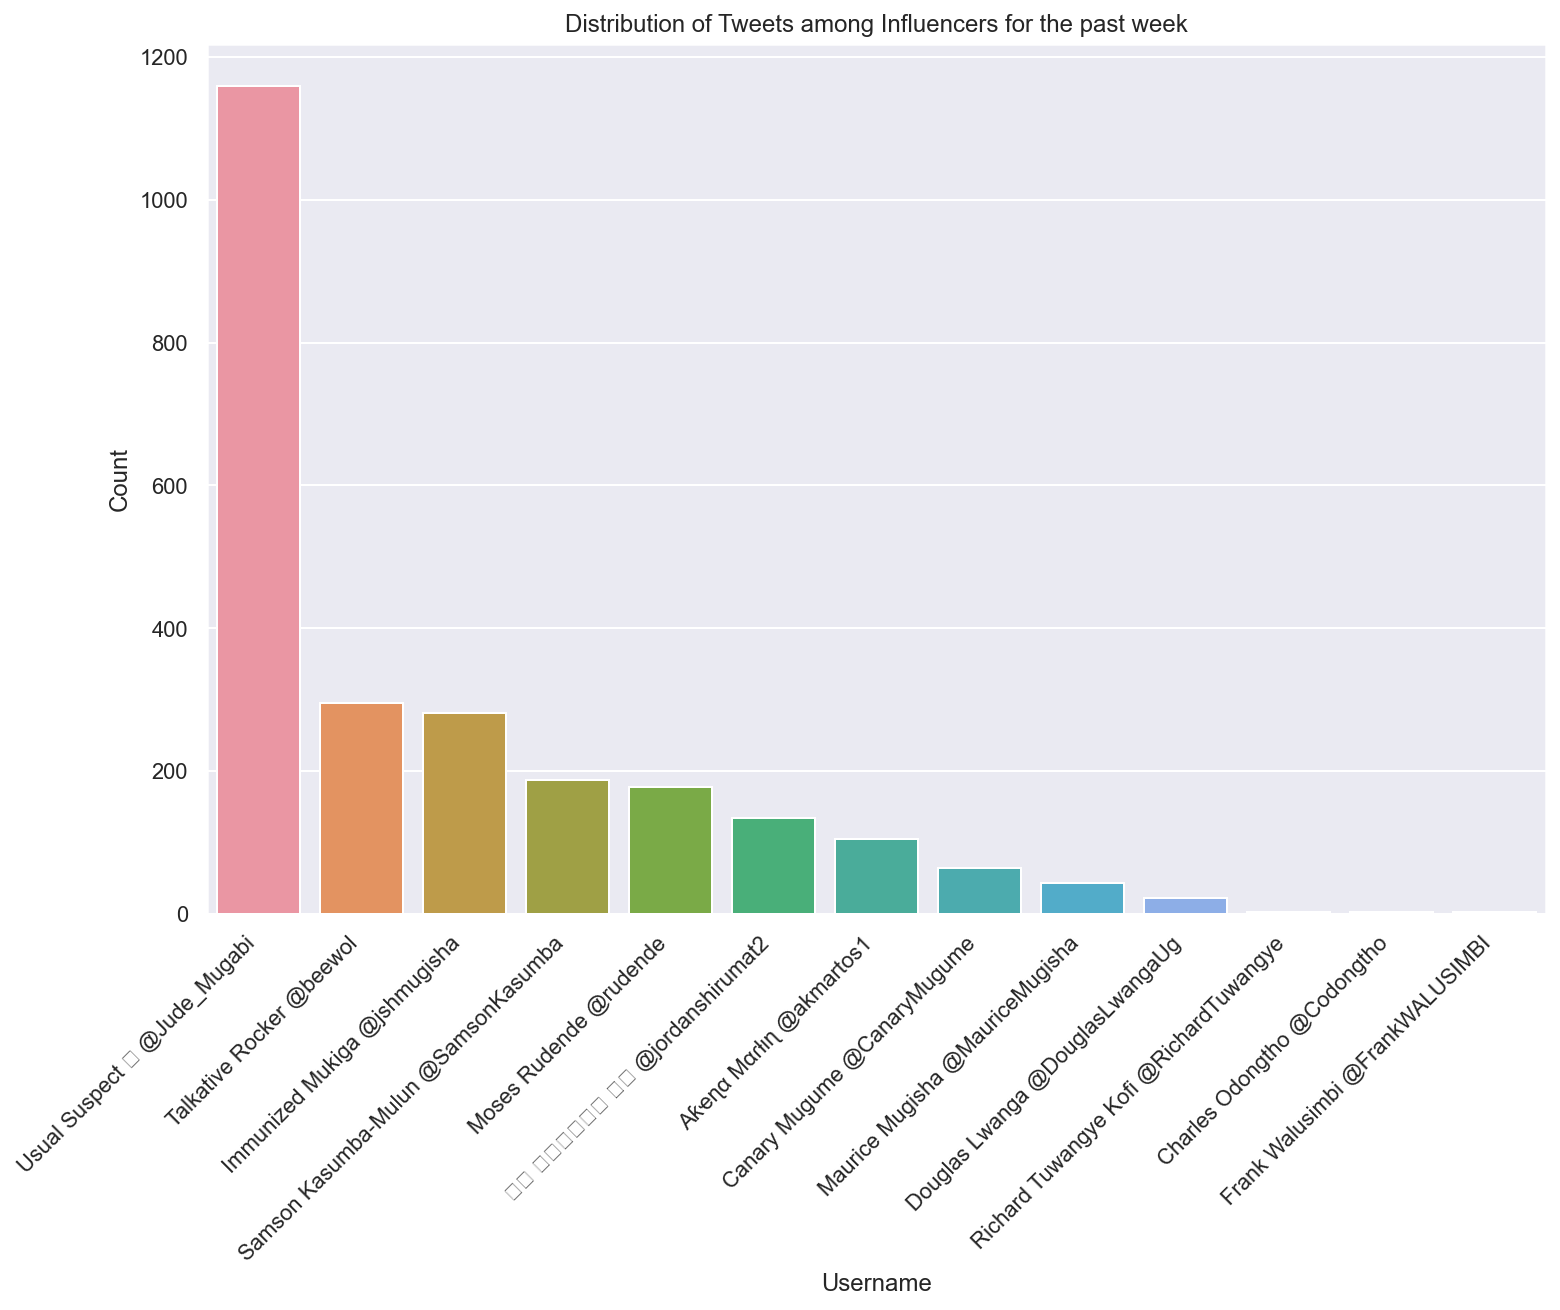

In [102]:
popular_users = usernames_df.nlargest(columns='Count', n=13)
_, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))

ax = sns.barplot(x='Username', y='Count', data=popular_users, ax=axes)
ax.set(ylabel="Count")
ax.set_title("Distribution of Tweets among Influencers for the past week")
ax.set_xticklabels(ax.get_xticklabels(),
                  rotation=45,
                  horizontalalignment='right')
plt.show()

Engagement that each influencer receives on their tweets.

**NOTE**: Engagement is the total number of retweets, replies, quotes and likes

In [103]:
columns_to_show = ["retweet_count", "reply_count", "quote_count", "like_count", "engagement"]

eng_df = df.groupby(['username'])[columns_to_show]

In [128]:
aggregate = eng_df.agg([np.mean])
average_engagement_df = pd.DataFrame({
    "Username": list(eng_df.groups.keys()),
    "Average Engagement": list(aggregate[('engagement', 'mean')])
})

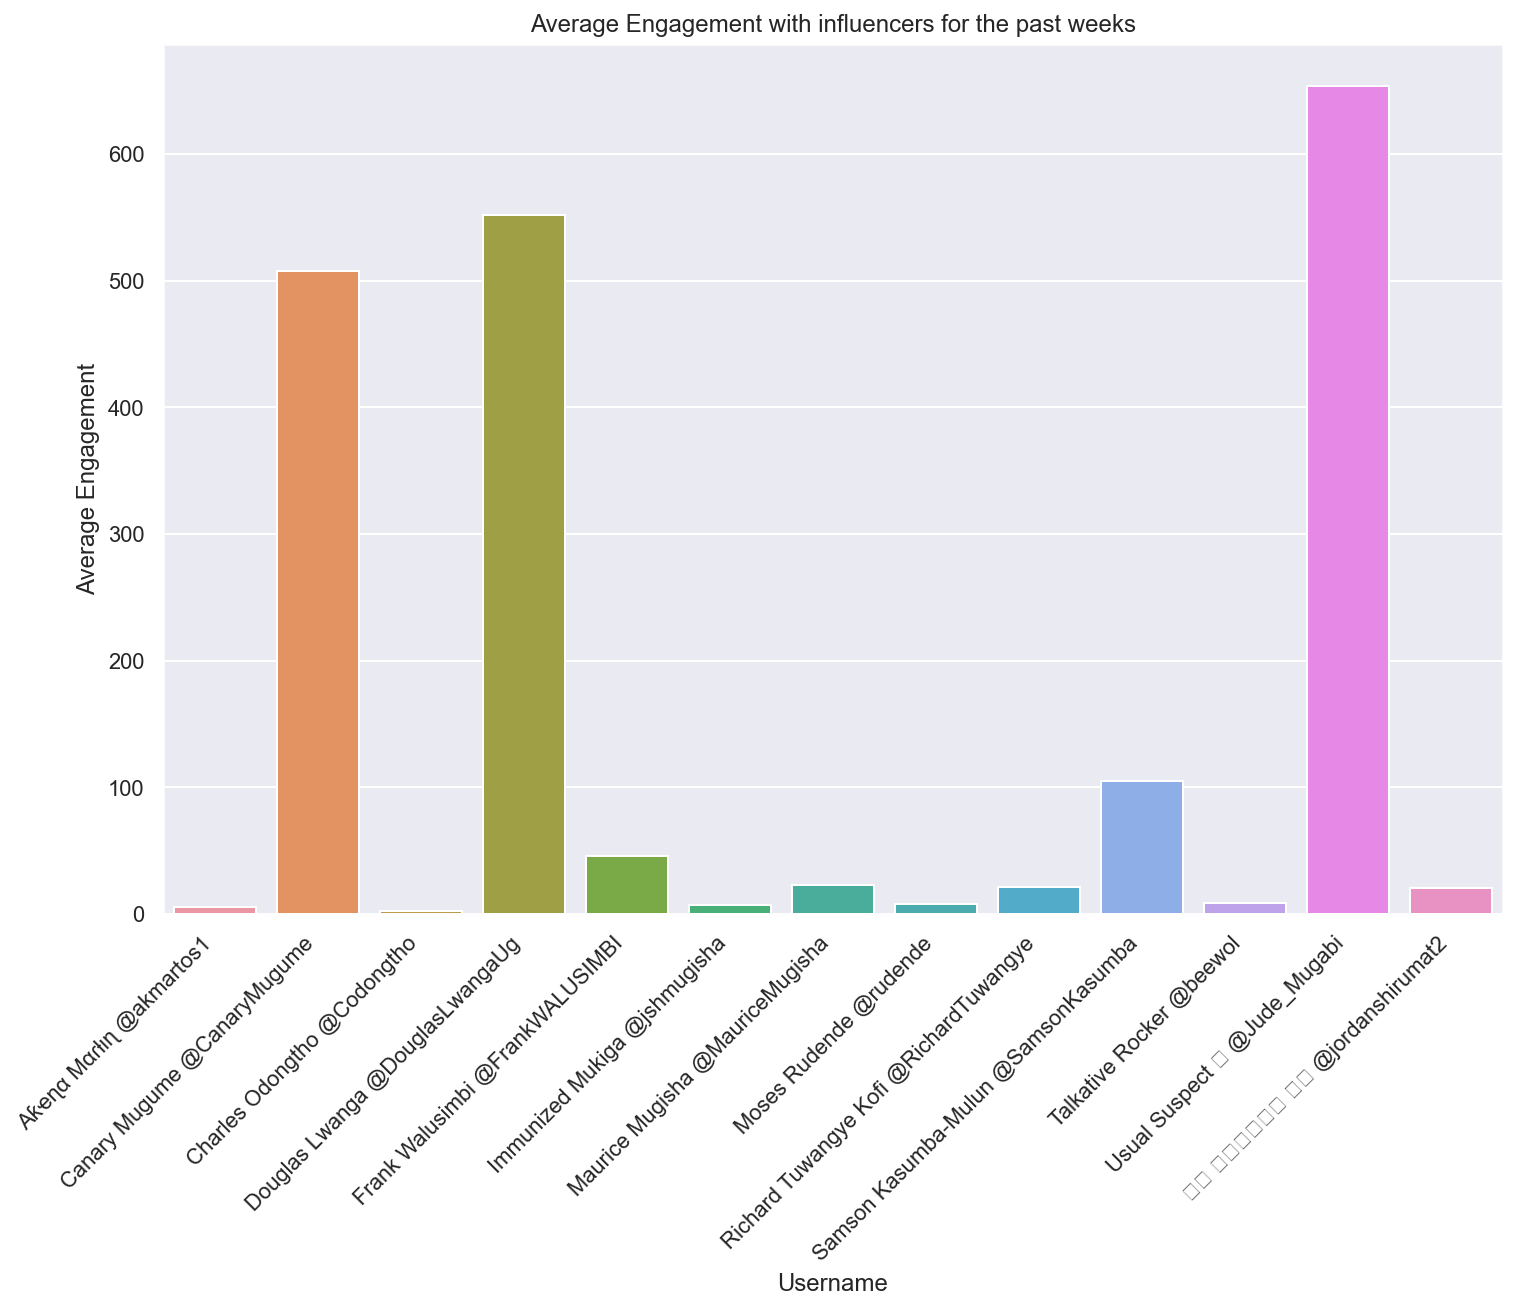

In [130]:
_, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))

ax = sns.barplot(x='Username', y="Average Engagement", data=average_engagement_df, ax=axes)
ax.set(ylabel='Average Engagement')
ax.set_title("Average Engagement of influencers tweets for the past weeks")
ax.set_xticklabels(ax.get_xticklabels(),
                  rotation=45,
                  horizontalalignment='right')
plt.show()

### Analysis of words in the influencers tweets for the last week

In [59]:
tweet_words = list(itertools.chain.from_iterable(df['words']))

<class 'str'>


In [60]:
wordcloud = WordCloud(width=800, height=500, random_state=20, max_font_size=110).generate(' '.join(tweet_words))

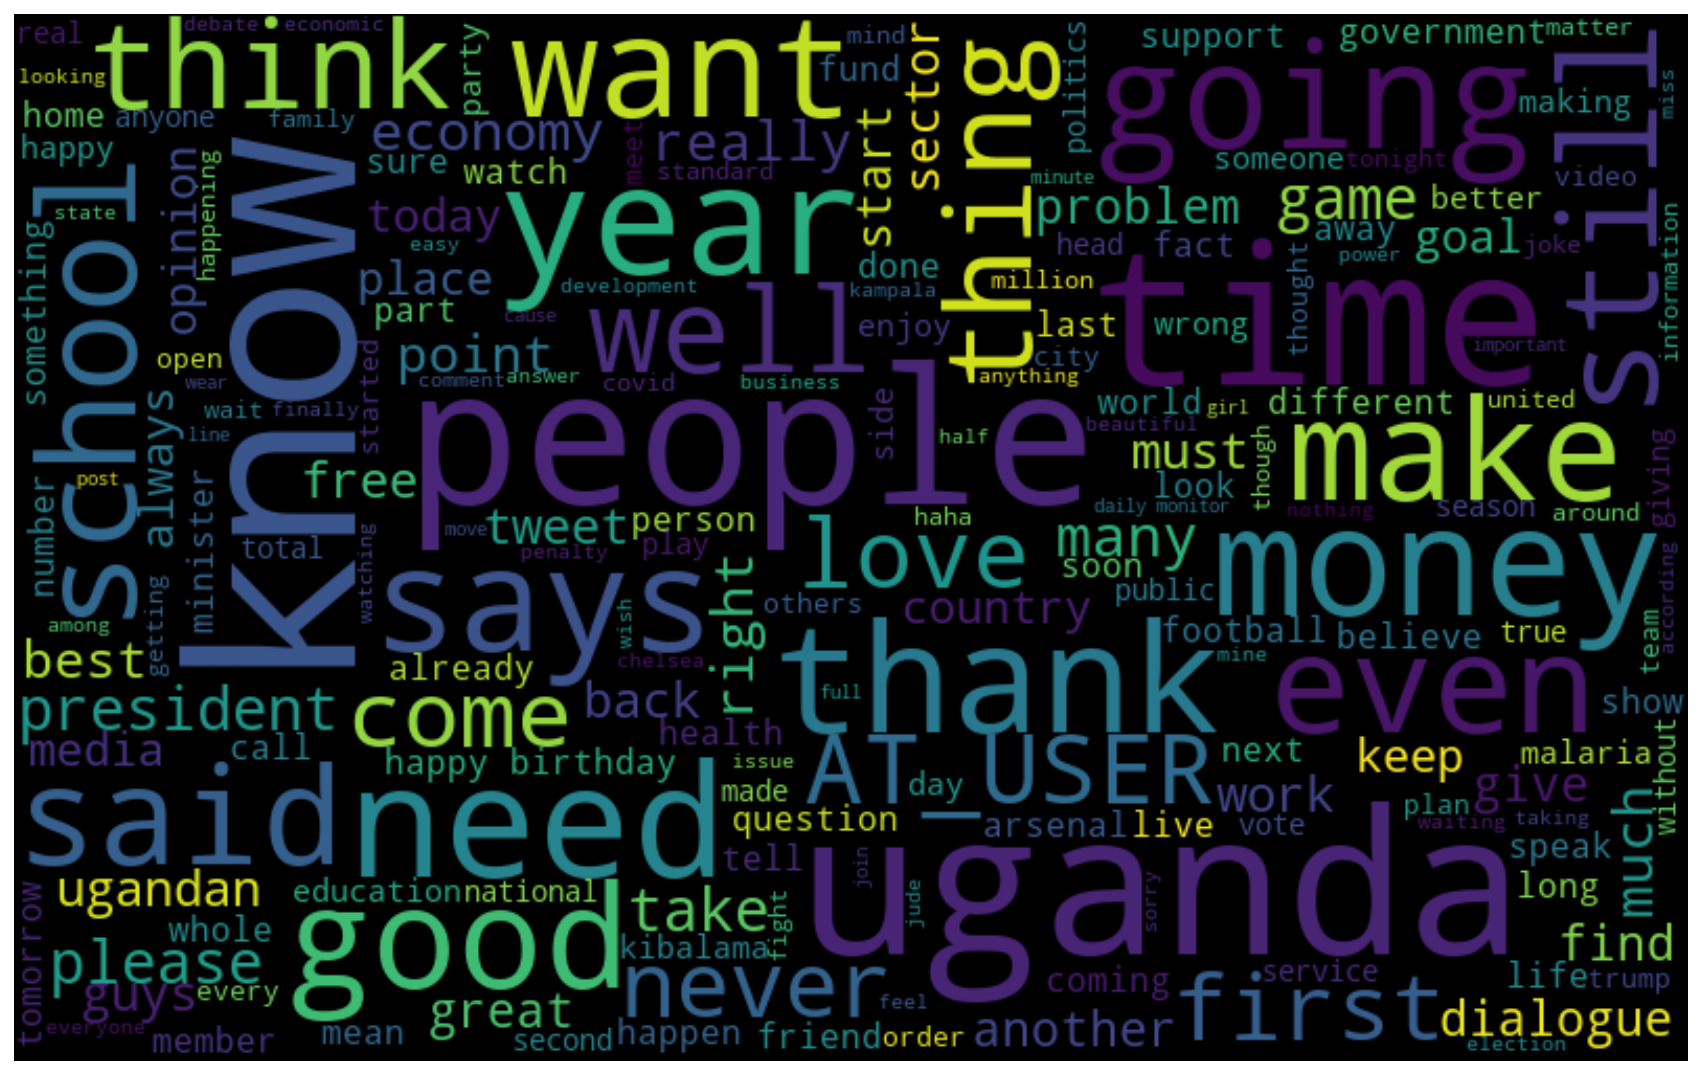

In [63]:
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()